# Neural Style Transfer
---

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optimization
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
from tqdm.notebook import tqdm

---
### Loading the Images

In [2]:
# Determine the device to use for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cuda


**Exercise 1 [5/5]**:
1. Using `transforms` to define the image `loader` that converts images to tensors using `ToTensor()` and normalizes them using ImageNet `mean` and `std`.

In [3]:
# Set the image size based on the availability of GPU
img_size = 512 if torch.cuda.is_available() else 128

In [4]:
# Define ImageNet mean and standard deviation for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [5]:
# Define the image transformation pipeline
loader = transforms.Compose([transforms.Resize(img_size), # Resize image
                             transforms.ToTensor(), # Convert image to tensor
                             transforms.Normalize(mean, std)]) # Normalize image with ImageNet stats

In [6]:
# Function to load and preprocess an image from the specified path
def load_img(path):

    img = Image.open(path) # Open image using PIL
    img = loader(img).unsqueeze(0) # Apply transformations and add batch dimension

    return img.to(device)

In [7]:
# Download the content and style images
!wget -O picasso.jpg https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget -O dancing.jpg https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

--2025-02-21 01:38:00--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.01s   

2025-02-21 01:38:00 (9.00 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2025-02-21 01:38:00--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0.002s  

2025-02-21 01:38:00 (17.6 MB/s)

In [8]:
# Load the content and style images into variables
content_img = load_img('dancing.jpg')
style_img = load_img('picasso.jpg')

**Exercise 2 [5/5]**:
1. Implement the `img_show`.

In [9]:
# Define an unloader for converting tensor back to PIL Image
unloader = transforms.ToPILImage()

In [10]:
# Function to display an image from a tensor after denormalization
def img_show(tensor, title = None):

    # Denormalize the image using the mean and standard deviation used for normalization
    denormalization = transforms.Normalize(mean = [-m / s for m, s in zip(mean, std)],
                                           std = [1 / s for s in std])

    img = tensor.clone().detach().cpu().squeeze(0) # Remove batch dimension and move tensor to CPU
    img = denormalization(img).clamp(0, 1) # Denormalize and clamp values between 0 and 1
    img = unloader(img) # Convert the tensor back to a PIL image

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()

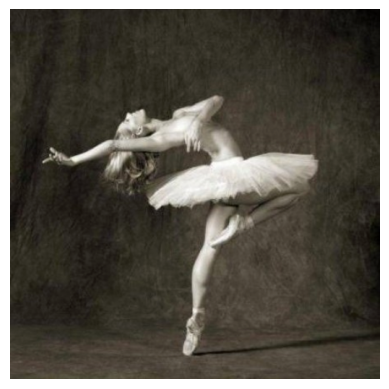

In [11]:
# Display the content image
plt.figure()
img_show(content_img)

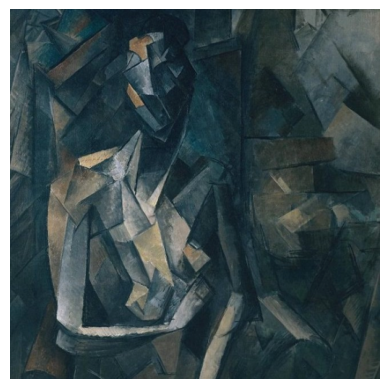

In [12]:
# Display the style image
plt.figure()
img_show(style_img)

---
### Importing the Pre-Trained Model

In [13]:
# Load the pre-trained VGG19 model with weights from ImageNet
vgg = vgg19(weights = VGG19_Weights.DEFAULT)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
# Extract the feature layers from the VGG19 model
vgg = vgg19(weights = VGG19_Weights.DEFAULT).features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

**Exercise 3 [20/20]**:
1. Implement a `VGG` class that loads a pretrained VGG-19 model and returns feature maps from a specified set of layers when an image is passed through the network.

In [15]:
# Define the custom VGG class for extracting feature maps from selected layers
class VGG(nn.Module):

  # Function to initialize the VGG model and specify which layers to extract features from
  def __init__(self):

      super(VGG, self).__init__()
      self.selected_layers = ['0', '5', '10', '19', '28'] # Layers to extract features from
      self.vgg = models.vgg19(weights = models.VGG19_Weights.DEFAULT).features # Load the VGG19 model

  # Function to pass the image through the network and extract features from the selected layers
  def forward(self, img):

      features = []
      x = img

      # Loop through the layers of VGG19
      for name, layer in enumerate(self.vgg):
          x = layer(x)
          if str(name) in self.selected_layers:
              features.append(x)

      return features

In [16]:
# Initialize the VGG model and move it to the selected device
vgg = VGG().to(device).eval()

In [17]:
# Pass the content image through the model and get the feature maps
content_feature = vgg(content_img)
print(f"content_feature[0].shape: {content_feature[0].shape}")

content_feature[0].shape: torch.Size([1, 64, 512, 512])


In [18]:
# Display the upper-left corner of the 10th feature map from the first layer
upper_left_corner = content_feature[0][0, 10, :5, :5]
print("Upper-left 5×5 corner of the 10th feature map at conv1_1:\n", upper_left_corner)

Upper-left 5×5 corner of the 10th feature map at conv1_1:
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4662, 0.2027, 0.1411, 0.1307, 0.1803],
        [0.4383, 0.1713, 0.1117, 0.0778, 0.1368],
        [0.4556, 0.1923, 0.1433, 0.1298, 0.1674],
        [0.4738, 0.2558, 0.2172, 0.2240, 0.2468]], device='cuda:0',
       grad_fn=<SliceBackward0>)


---
### Neural Style Transfer - Content Loss

**Exercise 4 [10/10]**:
1. Implement the `get_content_loss()` function to return the content loss between the `target` image and the `content` image.

In [19]:
# Function to compute and return the content loss between the target and content images
def get_content_loss(target, content):

  # Mean squared error between target and content images
  content_loss = torch.mean((target - content) ** 2)

  return content_loss

In [20]:
torch.manual_seed(0)
a_C = torch.randn(1, 3, 4, 4)
a_X = torch.randn(1, 3, 4, 4)

In [21]:
# Calculate content loss
content_loss = get_content_loss(a_C, a_X)
print(f"Content Loss: {content_loss.item():.6f}")

Content Loss: 1.818359


---
### Neural Style Transfer - Sytle Loss

**Exercise 5 [10/10]**:
1. Compute and return the Gram matrix of an `input` feature map with shape `[channels, height, width]`.

In [22]:
# Function to compute the Gram matrix of the input feature map
def gram_matrix(input, c, h, w):

  features = input.view(c, h * w) # Reshape input to a 2D matrix
  G = torch.mm(features, features.t()) # Compute the Gram matrix by multiplying the feature matrix with its transpose

  return G

In [23]:
torch.manual_seed(0)
test_input = torch.randn(1, 3, 4, 4)

In [24]:
# Calculate the Gram matrix
gram_result = gram_matrix(test_input, 3, 4, 4)
print("Gram Matrix:\n", gram_result)

Gram Matrix:
 tensor([[21.2884, -2.4347, -2.0579],
        [-2.4347, 15.8531, -3.4165],
        [-2.0579, -3.4165, 12.2586]], device='cuda:0')


**Exercise 6 [10/10]**:
1. Compute the style loss between two images using their gram matrices.

In [25]:
# Function to compute and return the style loss between target and style images
def get_style_loss(target, style):

  c, h, w = target[0].shape # Extract dimensions of the feature maps
  G = gram_matrix(target[0], c, h, w) # Compute the Gram matrix for the target image
  S = gram_matrix(style[0], c, h, w) # Compute the Gram matrix for the style image

  return torch.sum((G - S) ** 2) / (c * h * w) ** 2

In [26]:
torch.manual_seed(0)
a_S = torch.randn(1, 3, 4, 4)
a_G = torch.randn(1, 3, 4, 4)

In [27]:
# Calculate style loss
style_loss = get_style_loss(a_S, a_G)
print(f"Style Loss: {style_loss.item():.6f}")

Style Loss: 0.140521


---
### Neural Style Transfer - Total Loss

**Exercise 7 [10/10]**:
1. Combine and return the style and content losses with desired weights.

In [28]:
# Function to compute and return the total loss as a weighted sum of content and style losses
def get_total_loss(content_loss, style_loss, alpha = 1, beta = 1000000):

  # Weighted sum of content and style losses
  total_loss = alpha * content_loss + beta * style_loss

  return total_loss

In [29]:
# Calculate total loss with default weights
total_loss = get_total_loss(content_loss, style_loss)
print(f"Total Loss: {total_loss.item()}")

Total Loss: 140522.96875


In [30]:
# Calculate total loss with custom weights
total_loss = get_total_loss(content_loss, style_loss, alpha = 1, beta = 10)
print(f"Total Loss: {total_loss.item()}")

Total Loss: 3.2235708236694336


---
### Training

In [31]:
# Function to load an image and resize it to the target shape if specified
def load_img_with_target_shape(path, target_shape = None):

    # Load the image
    img = load_img(path)

    # Resize the image to the target shape
    if target_shape:
        img = transforms.Resize(target_shape)(img)

    return img

**Exercise 8 [10/10]**:
1. Initialize `target_img` as a copy of the content image.

In [32]:
style_img = load_img_with_target_shape("picasso.jpg", target_shape = content_img.shape[2:]) # Load the style image and resize it to the same size as the content image
target_img = content_img.clone().requires_grad_(True) # Initialize target_img as a copy of the content image and enable gradient computation

In [33]:
# Set up the Adam to optimize the target image
optimizer = optimization.Adam([target_img], lr = 0.01)

**Exercise 9 [20/20]**:
1. Using `vgg` to extract `target_feature`, `content_feature`, and `style_feature`.
2. Computing the cumulative `style_loss` and `content_loss` from the extracted features.
3. Calculating `total_loss` as a weighted sum of `style_loss` and `content_loss`.
4. Performing backpropagation on `target_img` and updating it using the predefined `optimizer`.

In [34]:
steps = 300

# Perform training for 300 steps
for step in tqdm(range(steps)):

    # Extract features for the target, content, and style images using VGG
    target_feature = vgg(target_img)
    content_feature = vgg(content_img)
    style_feature = vgg(style_img)

    # Initialize losses to 0
    style_loss = 0
    content_loss = 0

    # Compute content loss for each feature map by comparing target and content features
    for c, content_feat, target_feat in zip(content_feature, content_feature, target_feature):
        content_loss += get_content_loss(target_feat, content_feat)

    # Compute style loss for each feature map by comparing target and style features
    for s, style_feat, target_feat in zip(style_feature, style_feature, target_feature):
        style_loss += get_style_loss(target_feat, style_feat)

    # Compute total loss as a weighted sum of content and style losses
    total_loss = get_total_loss(content_loss, style_loss)

    # Perform backpropagation and update the target image using the optimizer
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
      print(f'step: {step}, content loss: {content_loss.item():.6f}, style loss: {style_loss.item():.6f}')

  0%|          | 0/300 [00:00<?, ?it/s]

step: 0, content loss: 0.000000, style loss: 1.124087
step: 50, content loss: 7.825956, style loss: 0.060208
step: 100, content loss: 8.171570, style loss: 0.039886
step: 150, content loss: 8.379202, style loss: 0.029769
step: 200, content loss: 8.562612, style loss: 0.022606
step: 250, content loss: 8.665236, style loss: 0.017535


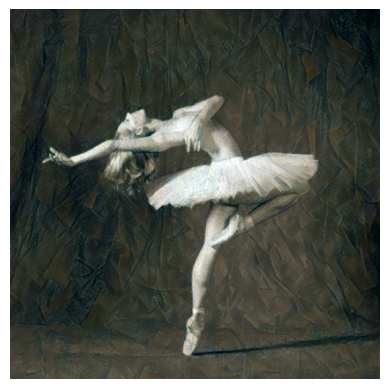

In [35]:
# Display the final result
plt.figure()
img_show(target_img)